In [1]:
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import help_functions as hf
from configs import configs
import urllib.parse
sys.path.append('../')

Using TensorFlow backend.


In [2]:
# Load config
config = configs[0]
print(config)

{'batch_size': 128, 'epochs': 50, 'image_dimension': 128, 'monitor': 'pr_auc', 'random_initialization': False, 'class_weights': False, 'hierarchical': False, 'loss_function': 'sample_weight', 'number_trainable_layers': 'all', 'data_folder': 'data/split_data_230412', 'results_folder': 'results_paper/230428_flatModel_sample_weight_monitorpr_auc_50epochs'}


In [3]:
# Load human-labeled set
human_df = pd.read_parquet('../../data/evaluation/annotated_validation.parquet')
human_df['labels'] = human_df.apply(lambda x: list(x.labels), axis=1) # otherwise the labels column will be a list of lists
human_df['url'] = human_df.apply(lambda x: x.url.split('/wikipedia/commons/')[1], axis=1)
human_df['url'] = human_df['url'].apply(lambda encoded_filename : urllib.parse.unquote(encoded_filename).encode().decode('unicode-escape'))

# As a result of the validation done in hf.get_flow, all .svg images are removed. And almost all of them are diagrams.
# That means that the diagrams category are subrepresented in the training and test set, don't correspond to reality.
# white_list_formats = ("png", "jpg", "jpeg", "bmp", "ppm", "tif", "tiff")
# def validate_filename(filename):
#     return filename.lower().endswith(white_list_formats) and os.path.isfile(filename) 

# human_df['is_valid'] = human_df['url'].apply(lambda filename : validate_filename(os.path.join('/scratch/WIT_Dataset/images', filename)))

# # print(human_df[human_df.is_valid == False].shape)
# # human_df[human_df.is_valid == False].head(30)

In [4]:
human, _ = hf.get_flow(df=human_df, 
                    batch_size=config['batch_size'], 
                    image_dimension=config['image_dimension'])

Found 285 validated image filenames belonging to 28 classes.


/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 42 invalid image filename(s) in x_col="url". These filename(s) will be ignored.
  warnings.warn(


In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve, auc, log_loss

In [6]:
# Create model
model = hf.create_model(n_labels=len(human.class_indices), image_dimension=config['image_dimension'], number_trainable_layers=config['number_trainable_layers'])
model_metrics_on_human_labeled_data = pd.DataFrame(columns=['precision', 'recall', 'f1_score', 'accuracy', 'loss', 'pr_auc'])


Number of layers in basemodel: 339
Number of trainable layers: 339

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 4, 4, 1408)        7768569   
_________________________________________________________________
flatten (Flatten)            (None, 22528)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2883712   
_________________________________________________________________
dense_1 (Dense)              (None, 28)                3612      
Total params: 10,655,893
Trainable params: 10,588,318
Non-trainable params: 67,575
_________________________________________________________________


In [7]:

for epoch in range(1, 51):
    # Load weights
    checkpoint_weights = f"{config['results_folder']}/cp-{epoch:04d}.ckpt"
    print(f'\nEvaluating model on human labels using chekpoing: {checkpoint_weights[-12:]}')
    model.load_weights(checkpoint_weights)

    # Predict labels
    probs = model.predict(human, verbose=2)
    y_pred = 1 * (probs > 0.5)
    y_true = hf.get_y_true(shape=(human.samples, len(human.class_indices)), classes=human.classes)

    # Generate metrics: loss, precision, recall, f1-score, PR_AUC, binary accuracy
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    accuracy = 0
    for sample in range(y_true.shape[0]):
        accuracy += accuracy_score(y_true[sample, :], y_pred[sample, :])
    accuracy = accuracy / y_true.shape[0]
    # TODO: loss

    # Compute the PR_AUC
    nr_labels = y_true.shape[1]
    pr_auc = dict()
    precisions = dict()
    recalls = dict()
    for i in range(nr_labels):
        precisions[i], recalls[i], _ = precision_recall_curve(y_true[:, i], probs[:, i])
        pr_auc[i] = auc(recalls[i], precisions[i])
    macro_pr_auc = np.array(list(pr_auc.values())).sum() / nr_labels
    # precisions, recalls, thresholds = precision_recall_curve(y_true, probs)
    # pr_auc = auc(recalls, precisions)

    # TODO: loss
    # positive_samples_per_class = np.sum(y_true, axis=0)
    # negative_samples_per_class = y_true.shape[0] - positive_samples_per_class
    # alpha_weights = negative_samples_per_class / positive_samples_per_class
    # alpha_weights = tf.cast(alpha_weights, tf.float32)
    # custom_loss = hf.get_custom_loss(alpha_weights)
    # loss = custom_loss(tf.cast(y_true, tf.float32), tf.cast(y_pred, tf.float32)).numpy()

    model_metrics_on_human_labeled_data.loc[epoch] = [precision, recall, f1, accuracy, -1, macro_pr_auc]
model_metrics_on_human_labeled_data.head(50)



Evaluating model on human labels using chekpoing: cp-0001.ckpt
3/3 - 1s

Evaluating model on human labels using chekpoing: cp-0002.ckpt
3/3 - 0s

Evaluating model on human labels using chekpoing: cp-0003.ckpt
3/3 - 0s

Evaluating model on human labels using chekpoing: cp-0004.ckpt
3/3 - 0s

Evaluating model on human labels using chekpoing: cp-0005.ckpt
3/3 - 0s

Evaluating model on human labels using chekpoing: cp-0006.ckpt
3/3 - 0s

Evaluating model on human labels using chekpoing: cp-0007.ckpt
3/3 - 0s

Evaluating model on human labels using chekpoing: cp-0008.ckpt
3/3 - 0s

Evaluating model on human labels using chekpoing: cp-0009.ckpt
3/3 - 0s

Evaluating model on human labels using chekpoing: cp-0010.ckpt
3/3 - 0s

Evaluating model on human labels using chekpoing: cp-0011.ckpt
3/3 - 0s

Evaluating model on human labels using chekpoing: cp-0012.ckpt
3/3 - 0s

Evaluating model on human labels using chekpoing: cp-0013.ckpt
3/3 - 0s

Evaluating model on human labels using chekpoing: 

,precision,recall,f1_score,accuracy,loss,pr_auc
1,0.195307,0.823299,0.279968,0.667794,-1.0,0.389726
2,0.215784,0.841190,0.303183,0.716792,-1.0,0.415161
3,0.207590,0.854739,0.297781,0.700125,-1.0,0.449568
4,0.217361,0.876009,0.312910,0.731704,-1.0,0.476390
5,0.223939,0.871198,0.321204,0.741980,-1.0,0.485382
6,0.229817,0.854560,0.325233,0.741855,-1.0,0.495392
7,0.232227,0.871543,0.328015,0.730326,-1.0,0.447712
8,0.221879,0.850290,0.316496,0.742356,-1.0,0.482939
9,0.213004,0.866282,0.309774,0.733584,-1.0,0.447089
10,0.231279,0.834517,0.330409,0.767043,-1.0,0.454281


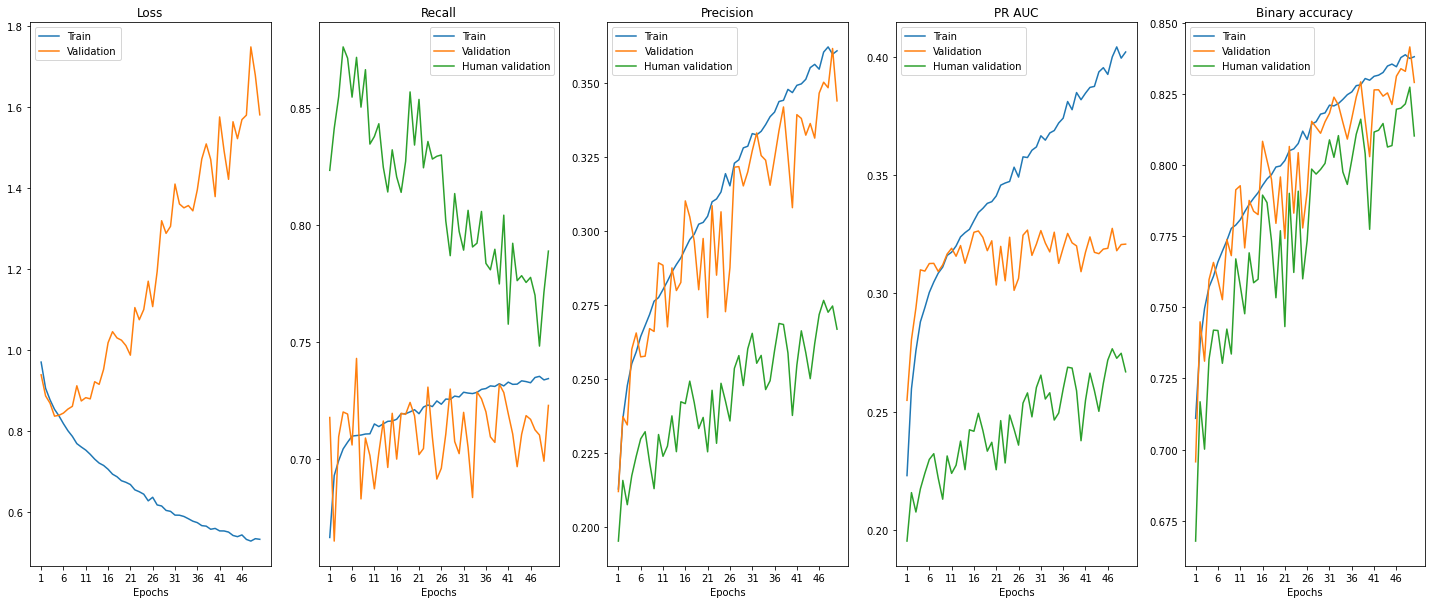

In [11]:
from matplotlib import pyplot as plt

training_metrics = pd.read_csv(config['results_folder'] + '/history.csv')

epochs = config['epochs']

plt.figure(figsize=(25,10))

_ = plt.subplot(1, 5, 1)
plt.plot(range(config['epochs']), training_metrics.loss.values, label='Training loss')
plt.plot(range(config['epochs']), training_metrics.val_loss.values, label='Validation loss')
# plt.plot(range(config['epochs']), model_metrics_on_human_labeled_data.loss, label='Loss against human-labeled data')
plt.xlabel('Epochs')
plt.title('Loss')
plt.xticks(np.arange(0, config['epochs'], step=5), np.arange(1, config['epochs']+1, step=5))
plt.legend(['Train', 'Validation', 'Human validation'])

_ = plt.subplot(1, 5, 2)
plt.plot(range(config['epochs']), training_metrics.recall.values, label='Training recall')
plt.plot(range(config['epochs']), training_metrics.val_recall.values, label='Validation recall')
plt.plot(range(config['epochs']), model_metrics_on_human_labeled_data.recall, label='Recall against human-labeled data')
plt.title('Recall')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, config['epochs'], step=5), np.arange(1, config['epochs']+1, step=5))
plt.legend(['Train', 'Validation', 'Human validation'])

_ = plt.subplot(1, 5, 3)
plt.plot(range(config['epochs']), training_metrics.precision.values, label='Training precision')
plt.plot(range(config['epochs']), training_metrics.val_precision.values, label='Validation precision')
plt.plot(range(config['epochs']), model_metrics_on_human_labeled_data.precision, label='Recall against human-labeled data')
plt.title('Precision')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, config['epochs'], step=5), np.arange(1, config['epochs']+1, step=5))
plt.legend(['Train', 'Validation', 'Human validation'])

_ = plt.subplot(1, 5, 4)
plt.plot(range(config['epochs']), training_metrics.pr_auc.values, label='Training PR_AUC')
plt.plot(range(config['epochs']), training_metrics.val_pr_auc.values, label='Validation PR_AUC')
plt.plot(range(config['epochs']), model_metrics_on_human_labeled_data.precision, label='PR_AUC against human-labeled data')
plt.title('PR AUC')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, config['epochs'], step=5), np.arange(1, config['epochs']+1, step=5))
plt.legend(['Train', 'Validation', 'Human validation'])

_ = plt.subplot(1, 5, 5)
plt.plot(range(config['epochs']), training_metrics.binary_accuracy.values, label='Training binary acc')
plt.plot(range(config['epochs']), training_metrics.val_binary_accuracy.values, label='Validation binary acc')
plt.plot(range(config['epochs']), model_metrics_on_human_labeled_data.accuracy, label='Recall against human-labeled data')
plt.title('Binary accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, config['epochs'], step=5), np.arange(1, config['epochs']+1, step=5))
plt.legend(['Train', 'Validation', 'Human validation'])

# hf.save_img(config['results_folder'] + '/training_metrics.png')